<a href="https://colab.research.google.com/github/Bertaalcolea/Collagen_studies/blob/main/Ionic_study2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files
uploaded = files.upload()


Saving Collgen_NaCl_KCl_Study2.xlsx to Collgen_NaCl_KCl_Study2 (1).xlsx


In [6]:
df = pd.read_excel(next(iter(uploaded)))
df.head()


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,Software Version,1.04.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Experiment File Path:,C:\Users\Plate Reader\Desktop\Wagner Lab\Berta...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Plate Number,Plate 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Date,2025-12-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.columns


Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25',
       'Unnamed: 26'],
      dtype='object')

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# =========================================================
# 1. CARGAR EXCEL DEL LECTOR (ya subido con files.upload())
# =========================================================
raw = pd.read_excel(next(iter(uploaded)), header=None)

# =========================================================
# 2. PARSEAR BLOQUES "350 - Time X (HH:MM:SS)" → formato largo
#    Solo va a coger los pozos 7–12 (que son los de este experimento)
# =========================================================
time_rows = raw.index[raw[0].astype(str).str.startswith("350 - Time", na=False)].tolist()

records = []

for t_idx in time_rows:
    # --- tiempo en minutos ---
    time_str = str(raw.iloc[t_idx, 0])   # ej: '350 - Time 1 (0:00:12)'
    m = re.search(r"\((\d+):(\d+):(\d+)\)", time_str)
    if m:
        h, mm, ss = map(int, m.groups())
        time_min = h*60 + mm + ss/60
    else:
        time_min = np.nan

    # --- buscar la fila de cabecera (1–12) justo después del "350 - Time..." ---
    header_row = None
    for r in range(t_idx+1, min(t_idx+20, len(raw))):
        vals = raw.iloc[r].tolist()
        nums = []
        for v in vals:
            if isinstance(v, (int, float)) and not pd.isna(v):
                nums.append(int(v))
            elif isinstance(v, str) and v.isdigit():
                nums.append(int(v))
        if set(range(1, 13)).issubset(set(nums)):
            header_row = r
            break
    if header_row is None:
        continue

    header = raw.iloc[header_row]

    # columnas donde están los números de pozo (aquí 7–12)
    well_cols = []
    for j, v in enumerate(header):
        if isinstance(v, (int, float)) and not pd.isna(v) and int(v) in range(7, 13):
            well_cols.append(j)
        elif isinstance(v, str) and v.isdigit() and int(v) in range(7, 13):
            well_cols.append(j)

    # --- filas A–H justo debajo de la cabecera ---
    for offset in range(1, 9):  # 8 filas A–H
        rr = header_row + offset
        if rr >= len(raw):
            break
        row_label = raw.iloc[rr, 1]    # la letra A–H está en la columna 1
        if row_label not in list("ABCDEFGH"):
            continue

        for j in well_cols:
            col_num = int(raw.iloc[header_row, j])  # número de pozo (7–12)
            od = raw.iloc[rr, j]
            if pd.isna(od):
                continue
            records.append({
                "time_min": time_min,
                "row": row_label,
                "col": col_num,
                "OD": float(od),
            })

long_df = pd.DataFrame(records)
long_df["well"] = long_df["row"] + long_df["col"].astype(str)

print(long_df.head())
print("Nº de filas:", len(long_df))
print("Pozos únicos:", long_df[["row","col"]].drop_duplicates())


   time_min row  col     OD well
0       0.2   A    7  0.174   A7
1       0.2   A    8  0.175   A8
2       0.2   A    9  0.176   A9
3       0.2   A   10  0.177  A10
4       0.2   A   11  0.175  A11
Nº de filas: 5445
Pozos únicos:    row  col
0    A    7
1    A    8
2    A    9
3    A   10
4    A   11
5    A   12
6    B    7
7    B    8
8    B    9
9    B   10
10   B   11
11   B   12
12   C    7
13   C    8
14   C    9
15   C   10
16   C   11
17   C   12
18   D    7
19   D    8
20   D    9
21   D   10
22   D   11
23   D   12
24   E    7
25   E    8
26   E    9
27   E   10
28   E   11
29   E   12
30   F    7
31   F    8
32   F    9
33   F   10
34   F   11
35   F   12
36   G    7
37   G    8
38   G    9
39   G   10
40   G   11
41   G   12
42   H   10
43   H   11
44   H   12


In [22]:
def classify_cond(row):
    r = row["row"]
    c = row["col"]

    # --- Control (sin sal) ---
    if r == "G" and c in [7, 8, 9]:
        return "Control (no salt)"

    # --- NaCl bovino ---
    if r == "A" and c in [7, 8, 9]:
        return "Bov NaCl commercial"
    if r == "B" and c in [7, 8, 9]:
        return "Bov NaCl 200 mM "
    if r == "C" and c in [7, 8, 9]:
        return "Bov NaCl 137 mM pH6 "
    if r == "H" and c in [10, 11, 12]:
        return "Bov NaCl 137 mM pH7 "

    # --- NaCl rata ---
    if r == "D" and c in [7, 8, 9]:
        return "Rat NaCl commercial "
    if r == "E" and c in [7, 8, 9]:
        return "Rat NaCl 200 mM "
    if r == "F" and c in [7, 8, 9]:
        return "Rat NaCl 137 mM pH6 "
    if r == "G" and c in [10, 11, 12]:
        return "Rat NaCl 137 mM pH7 "

    # --- KCl bovino ---
    if r == "A" and c in [10, 11, 12]:
        return "Bov KCl commercial "
    if r == "B" and c in [10, 11, 12]:
        return "Bov KCl 200 mM "
    if r == "C" and c in [10, 11, 12]:
        return "Bov KCl 137 mM pH6 "

    # --- KCl rata ---
    if r == "D" and c in [10, 11, 12]:
        return "Rat KCl commercial "
    if r == "E" and c in [10, 11, 12]:
        return "Rat KCl 200 mM "
    if r == "F" and c in [10, 11, 12]:
        return "Rat KCl 137 mM pH6 "

    return "Other"

long_df["cond"] = long_df.apply(classify_cond, axis=1)

long_df["cond"].value_counts()


,count
cond,
Bov NaCl commercial,363
Bov KCl commercial,363
Bov NaCl 200 mM,363
Bov KCl 200 mM,363
Bov NaCl 137 mM pH6,363
Bov KCl 137 mM pH6,363
Rat NaCl commercial,363
Rat KCl commercial,363
Rat NaCl 200 mM,363


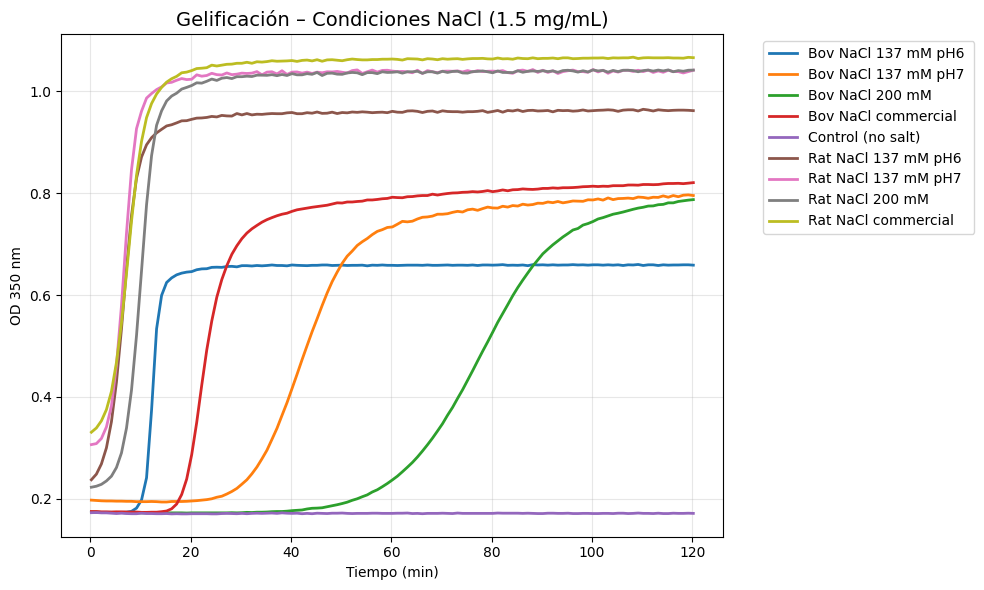

In [16]:
# =============================
# N a C l
# =============================
nacl_df = long_df[long_df["cond"].str.contains("NaCl") |
                  (long_df["cond"] == "Control (no salt)")]

nacl_mean = (
    nacl_df
    .groupby(["time_min", "cond"])["OD"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))

palette = plt.cm.tab20(range(nacl_mean["cond"].nunique()))

for i, (cond, sub) in enumerate(nacl_mean.groupby("cond")):
    sub = sub.sort_values("time_min")
    plt.plot(sub["time_min"], sub["OD"],
             label=cond,
             linewidth=2)

plt.title("Gelificación – Condiciones NaCl (1.5 mg/mL)", fontsize=14)
plt.xlabel("Tiempo (min)")
plt.ylabel("OD 350 nm")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


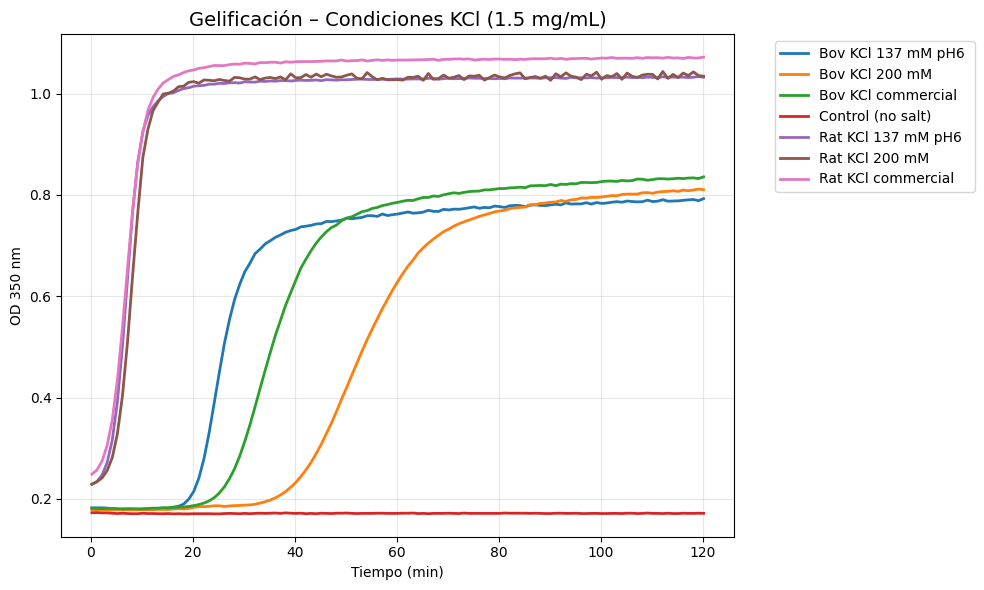

In [23]:
# =============================
# K C l  +  Control
# =============================

kcl_df = long_df[
    long_df["cond"].str.contains("KCl") |
    (long_df["cond"] == "Control (no salt)")
]

kcl_mean = (
    kcl_df
    .groupby(["time_min", "cond"])["OD"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))

palette = plt.cm.tab20(range(kcl_mean["cond"].nunique()))

for i, (cond, sub) in enumerate(kcl_mean.groupby("cond")):
    sub = sub.sort_values("time_min")
    plt.plot(sub["time_min"], sub["OD"],
             label=cond,
             linewidth=2)

plt.title("Gelificación – Condiciones KCl (1.5 mg/mL)", fontsize=14)
plt.xlabel("Tiempo (min)")
plt.ylabel("OD 350 nm")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [24]:
def get_style(cond_name):

    # ====================
    # COLOR por especie
    # ====================
    if cond_name.startswith("Bov "):
        base_color = "red"
    elif cond_name.startswith("Rat "):
        base_color = "blue"
    else:
        base_color = "black"

    # ====================
    # OSCURECER si es pH 7
    # ====================
    if "pH7" in cond_name or "pH 7" in cond_name:
        # colores más oscuros
        if base_color == "red":
            color = "#7f0000"   # rojo oscuro
        elif base_color == "blue":
            color = "#00007f"   # azul oscuro
        else:
            color = "black"
    else:
        color = base_color

    # ====================
    # ESTILO de línea
    # ====================
    if "137 mM" in cond_name:
        linestyle = "-"
    elif "200 mM" in cond_name:
        linestyle = "--"
    elif "commercial" in cond_name.lower():
        linestyle = ":"
    elif "Control" in cond_name:
        linestyle = "-."
    else:
        linestyle = "-"

    return color, linestyle


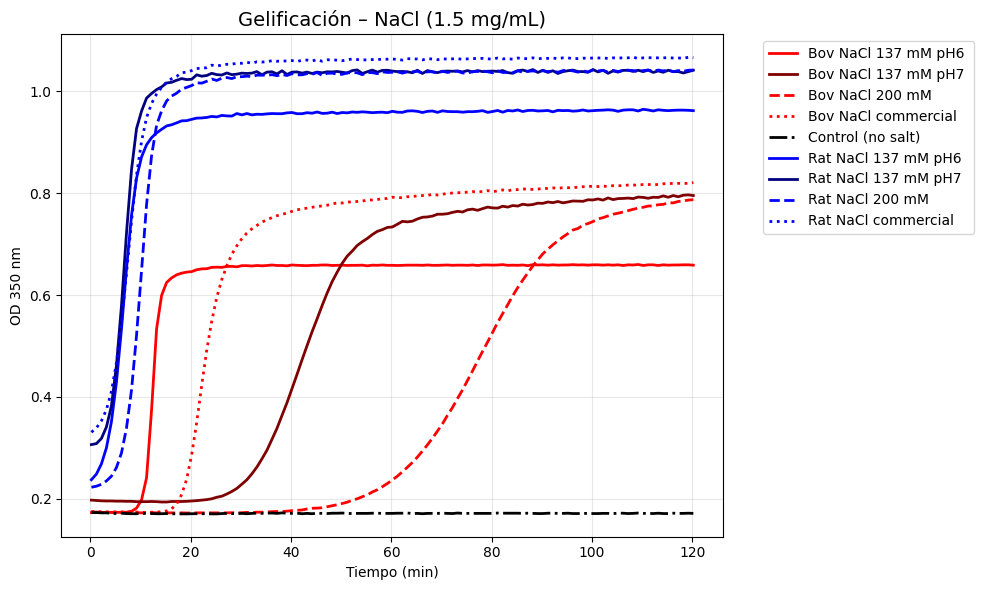

In [25]:
plt.figure(figsize=(10, 6))

for cond, sub in nacl_mean.groupby("cond"):
    sub = sub.sort_values("time_min")
    color, linestyle = get_style(cond)
    plt.plot(
        sub["time_min"], sub["OD"],
        label=cond,
        color=color,
        linestyle=linestyle,
        linewidth=2
    )

plt.title("Gelificación – NaCl (1.5 mg/mL)", fontsize=14)
plt.xlabel("Tiempo (min)")
plt.ylabel("OD 350 nm")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


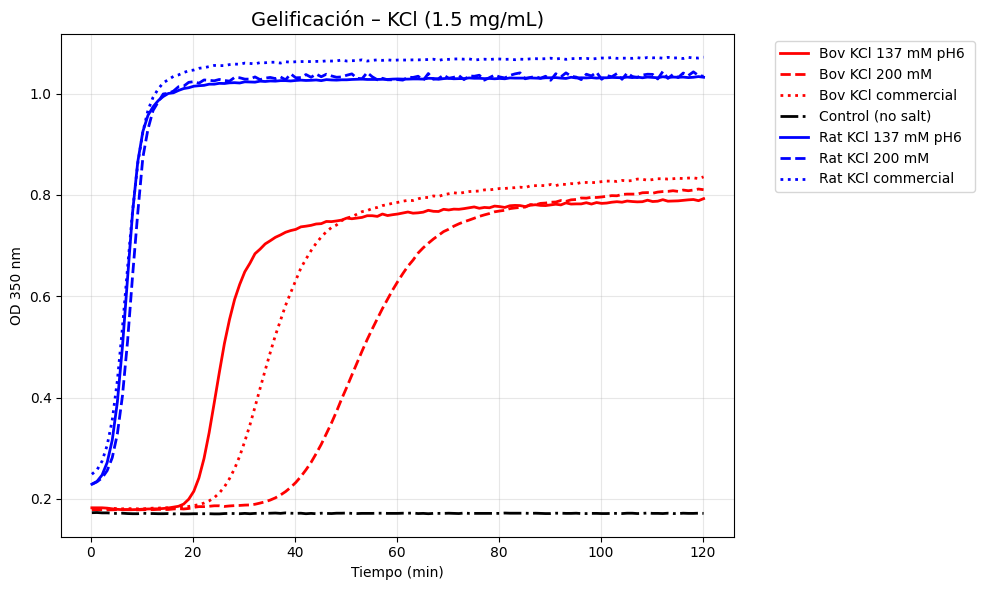

In [26]:
plt.figure(figsize=(10, 6))

for cond, sub in kcl_mean.groupby("cond"):
    sub = sub.sort_values("time_min")
    color, linestyle = get_style(cond)
    plt.plot(
        sub["time_min"], sub["OD"],
        label=cond,
        color=color,
        linestyle=linestyle,
        linewidth=2
    )

plt.title("Gelificación – KCl (1.5 mg/mL)", fontsize=14)
plt.xlabel("Tiempo (min)")
plt.ylabel("OD 350 nm")
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
